In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [ ]:
pip install mlflow

In [5]:
import mlflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('Housing2')

<Experiment: artifact_location='file:///c:/Users/Victoria/pro/MLOp/Housing_Prediction/experiment_tracking/mlruns/2', creation_time=1713176012400, experiment_id='2', last_update_time=1713176012400, lifecycle_stage='active', name='Housing2', tags={}>

In [6]:
df = pd.read_csv('C:/Users/Victoria/pro/MLOp/Housing_Prediction/Training.csv')

In [7]:
import pandas as pd
def read_dataframe(filename):
    df = pd.read_csv(filename)
    df = df.drop('Id', axis=1)
    df = df.drop(columns = ['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

    df = df[df.Neighborhood == 'Avondale']
    df = df[(df.SalePrice >= 100000) & (df.SalePrice <= 500000)]

    categorical = ['BedroomAbvGr', 'GarageCars']
    df[categorical].astype(str)

    return df

# df[categorical].astype(str).dtypes


In [8]:
df_train = read_dataframe('C:/Users/Victoria/pro/MLOp/Housing_Prediction/Training.csv')
df_val = read_dataframe('C:/Users/Victoria/pro/MLOp/Housing_Prediction/Validation.csv')

In [9]:
len(df_train), len(df_val)

(288, 49)

In [10]:
df_train['BedroomAbvGr'] = df_train['BedroomAbvGr'].astype(str)
df_train['GarageCars'] = df_train['GarageCars'].astype(str)

df_train['BED_GAR'] = df_train['BedroomAbvGr'] + '_' + df_train['GarageCars']

df_val['BedroomAbvGr'] = df_val['BedroomAbvGr'].astype(str)
df_val['GarageCars'] = df_val['GarageCars'].astype(str)

df_val['BED_GAR'] = df_val['BedroomAbvGr'] + '_' + df_val['GarageCars']


In [ ]:
df_val

In [12]:
categorical = ['BED_GAR']#'BedroomAbvGr', 'GarageCars']
numerical = ['GarageArea']

dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [13]:
target = 'SalePrice'
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

36147.195326956426

In [15]:
la = Lasso(alpha=10000000)
la.fit(X_train, y_train)

y_pred = la.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

25833.66489247413

In [16]:
if not os.path.exists('models'):
    os.makedirs('models')

# original code to save the file
with open('models/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, la), f_out)

In [22]:
with mlflow.start_run():

    mlflow.set_tag('Developer', 'Victoria')

    mlflow.log_param('Train', 'C:/Users/Victoria/pro/MLOp/Housing_Prediction/Training.csv')
    mlflow.log_param('Valid', 'C:/Users/Victoria/pro/MLOp/Housing_Prediction/Validation.csv')
    
    alpha=100000000
    
    lr = Ridge(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

In [ ]:
pip install hyperopt

In [23]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [26]:
def objective(params):
      #  params = log and visualize parameters using MLflow
  with mlflow.start_run():
     mlflow.set_tag('model', 'xgboost')
     mlflow.log_params(params)
     booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
     )
     y_pred = booster.predict(valid)
     rmse = mean_squared_error(y_val, y_pred, squared=False)
     mlflow.log_metric('rmse', rmse)

  return {'loss': rmse, 'status': STATUS_OK}

In [27]:
 search_space = {
     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
     'learning_rate': hp.loguniform('learning_rate', -3, 0),
     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
     'reg_lambda': hp.loguniform('reg_lamba', -6, -1),
     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
     'objective': 'reg:linear',
     'seed': 42,
 }

 best_result = fmin(
     fn=objective,
     space=search_space,
     algo=tpe.suggest,
     max_evals=50,
     trials=Trials())

[0]	validation-rmse:27510.13638                       
[1]	validation-rmse:29245.85087                       
[2]	validation-rmse:30931.49346                       
[3]	validation-rmse:32478.78448                       
[4]	validation-rmse:33944.32232                       
[5]	validation-rmse:35294.62999                       
[6]	validation-rmse:36544.83469                       
[7]	validation-rmse:37676.48559                       
[8]	validation-rmse:38685.86686                       
[9]	validation-rmse:39618.00124                       
[10]	validation-rmse:40487.47446                      
[11]	validation-rmse:41254.18586                      
[12]	validation-rmse:41969.07314                      
[13]	validation-rmse:42609.78352                      
[14]	validation-rmse:43152.52603                      
[15]	validation-rmse:43657.15292                      
[16]	validation-rmse:43990.81404                      
[17]	validation-rmse:44405.14025                      
[18]	valid

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:04:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[48]	validation-rmse:47349.86977                      
[49]	validation-rmse:47362.63912                      
[0]	validation-rmse:26374.34226                                                
[1]	validation-rmse:26947.66307                                                
[2]	validation-rmse:27514.64629                                                
[3]	validation-rmse:28463.35170                                                
[4]	validation-rmse:29023.91583                                                
[5]	validation-rmse:29553.60794                                                
[6]	validation-rmse:30365.35678                                                
[7]	validation-rmse:31159.54742                                                
[8]	validation-rmse:31719.00949                                                
[9]	validation-rmse:32163.51290                                                
[10]	validation-rmse:32706.30078                                               
[11]	valid

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:27170.64775                                                
[1]	validation-rmse:28619.03763                                               
[2]	validation-rmse:30018.52161                                               
[3]	validation-rmse:31526.99000                                               
[4]	validation-rmse:32628.62887                                               
[5]	validation-rmse:33775.92957                                               
[6]	validation-rmse:34558.43182                                               
[7]	validation-rmse:35277.19299                                               
[8]	validation-rmse:35851.61007                                               
[9]	validation-rmse:36488.56193                                               
[10]	validation-rmse:36879.23385                                              
[11]	validation-rmse:37406.07122                                              
[12]	validation-rmse:37633.76620                   

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:04:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:27040.17030                                                 
[1]	validation-rmse:28255.57563                                                 
[2]	validation-rmse:29473.48265                                                 
[3]	validation-rmse:30662.84269                                                 
[4]	validation-rmse:31797.35227                                                 
[5]	validation-rmse:32865.73485                                                 
[6]	validation-rmse:33902.42047                                                 
[7]	validation-rmse:34885.74945                                                 
[8]	validation-rmse:35794.94675                                                 
[9]	validation-rmse:36678.86475                                                 
[10]	validation-rmse:37425.23895                                                
[11]	validation-rmse:38124.58279                                                
[12]	validation-rmse:38789.6

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:04:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[39]	validation-rmse:46280.18844                                                
[40]	validation-rmse:46363.15407                                                
[41]	validation-rmse:46432.82087                                                
[42]	validation-rmse:46501.33802                                                
[43]	validation-rmse:46561.02126                                                
[44]	validation-rmse:46619.79963                                                
[45]	validation-rmse:46676.33508                                                
[46]	validation-rmse:46724.33846                                                
[47]	validation-rmse:46770.65221                                                
[48]	validation-rmse:46815.50682                                                
[49]	validation-rmse:46853.85613                                                
[0]	validation-rmse:31517.54011                                                 
[1]	validation-rmse:36223.65

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[45]	validation-rmse:47903.86929                                                
[46]	validation-rmse:47903.86908                                                
[47]	validation-rmse:47903.86891                                                
[48]	validation-rmse:47903.86870                                                
[49]	validation-rmse:47903.86848                                                
[50]	validation-rmse:47903.86831                                                
[0]	validation-rmse:27118.48831                                                 
[1]	validation-rmse:28380.09985                                                 
[2]	validation-rmse:29434.64688                                                 
[3]	validation-rmse:30544.60753                                                 
[4]	validation-rmse:31437.79985                                                 
[5]	validation-rmse:32451.98543                                                 
[6]	validation-rmse:33521.38

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:45168.56799                                                
[44]	validation-rmse:45221.33551                                                
[45]	validation-rmse:45305.78325                                                
[46]	validation-rmse:45342.45327                                                
[47]	validation-rmse:45349.97191                                                
[48]	validation-rmse:45441.77887                                                
[49]	validation-rmse:45554.17911                                                
[0]	validation-rmse:34793.25456                                                 
[1]	validation-rmse:38385.72486                                                 
[2]	validation-rmse:39649.68591                                                 
[3]	validation-rmse:38052.67301                                                 
[4]	validation-rmse:39571.03105                                                 
[5]	validation-rmse:39715.34

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:27327.31393                                                 
[1]	validation-rmse:28850.46180                                                 
[2]	validation-rmse:29783.80268                                                 
[3]	validation-rmse:30958.76898                                                 
[4]	validation-rmse:32066.75611                                                 
[5]	validation-rmse:32938.63766                                                 
[6]	validation-rmse:33891.84902                                                 
[7]	validation-rmse:34682.76854                                                 
[8]	validation-rmse:35528.74488                                                 
[9]	validation-rmse:36127.69378                                                 
[10]	validation-rmse:36921.02746                                                
[11]	validation-rmse:37541.14168                                                
[12]	validation-rmse:38125.7

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:26618.39708                                                 
[1]	validation-rmse:27420.83952                                                 
[2]	validation-rmse:28229.04577                                                 
[3]	validation-rmse:29033.59366                                                 
[4]	validation-rmse:29816.31162                                                 
[5]	validation-rmse:30606.89494                                                 
[6]	validation-rmse:31368.43876                                                 
[7]	validation-rmse:32110.02632                                                 
[8]	validation-rmse:32840.03965                                                 
[9]	validation-rmse:33536.43661                                                 
[10]	validation-rmse:34209.01445                                                
[11]	validation-rmse:34866.79393                                                
[12]	validation-rmse:35490.6

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[36]	validation-rmse:43915.33562                                                
[37]	validation-rmse:44095.56126                                                
[38]	validation-rmse:44266.89381                                                
[39]	validation-rmse:44430.34365                                                
[40]	validation-rmse:44586.00661                                                
[41]	validation-rmse:44734.05434                                                
[42]	validation-rmse:44874.84793                                                
[43]	validation-rmse:45012.36887                                                
[44]	validation-rmse:45139.81045                                                
[45]	validation-rmse:45264.38618                                                
[46]	validation-rmse:45379.71175                                                
[47]	validation-rmse:45492.53291                                                
[48]	validation-rmse:45599.8

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:33503.79757                                                  
[1]	validation-rmse:36958.98640                                                  
[2]	validation-rmse:37931.12964                                                  
[3]	validation-rmse:38949.46490                                                  
[4]	validation-rmse:38815.49122                                                  
[5]	validation-rmse:38632.81154                                                  
[6]	validation-rmse:38827.12167                                                  
[7]	validation-rmse:38757.48771                                                  
[8]	validation-rmse:38497.90112                                                  
[9]	validation-rmse:38692.98613                                                  
[10]	validation-rmse:38872.20125                                                 
[11]	validation-rmse:38929.54690                                                 
[12]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:42063.15839
[45]	validation-rmse:42288.69697                                                 
[46]	validation-rmse:42123.83308                                                 
[47]	validation-rmse:42151.33458                                                 
[48]	validation-rmse:42282.13950                                                 
[49]	validation-rmse:42231.39046                                                 
[0]	validation-rmse:42631.29355                                                  
[1]	validation-rmse:45986.45368                                                  
[2]	validation-rmse:46890.45219                                                  
[3]	validation-rmse:47541.03646                                                  
[4]	validation-rmse:47253.80216                                                  
[5]	validation-rmse:48180.14065                                                  
[6]	validation-rmse:48328.83079                                  

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:51832.87180                                                 
[45]	validation-rmse:51796.40767                                                 
[46]	validation-rmse:51805.25316                                                 
[47]	validation-rmse:51806.93999                                                 
[48]	validation-rmse:51827.26280                                                 
[49]	validation-rmse:51833.79305                                                 
[0]	validation-rmse:27778.81263                                                  
[1]	validation-rmse:29665.14315                                                  
[2]	validation-rmse:31415.30563                                                  
[3]	validation-rmse:32436.39848                                                  
[4]	validation-rmse:33390.62110                                                  
[5]	validation-rmse:34500.37790                                                  
[6]	validation-r

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:45609.28363                                                 
[41]	validation-rmse:45571.43067                                                 
[42]	validation-rmse:45650.00799                                                 
[43]	validation-rmse:45605.70136                                                 
[44]	validation-rmse:45628.22689                                                 
[45]	validation-rmse:45718.32513                                                 
[46]	validation-rmse:45726.14404                                                 
[47]	validation-rmse:45639.74507                                                 
[48]	validation-rmse:45620.35685                                                 
[49]	validation-rmse:45675.14931                                                 
[50]	validation-rmse:45731.99445                                                 
[0]	validation-rmse:28487.79899                                                  
[1]	validation-r

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:41550.58781                                                 
[31]	validation-rmse:41625.92984                                                 
[32]	validation-rmse:41611.08655                                                 
[33]	validation-rmse:41485.95060                                                 
[34]	validation-rmse:41468.33024                                                 
[35]	validation-rmse:41666.81159                                                 
[36]	validation-rmse:42010.85059                                                 
[37]	validation-rmse:41941.19241                                                 
[38]	validation-rmse:42206.17352                                                 
[39]	validation-rmse:42055.31704                                                 
[40]	validation-rmse:42158.34780                                                 
[41]	validation-rmse:42247.21038                                                 
[42]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:47097.07153                                                 
[42]	validation-rmse:47182.05492                                                 
[43]	validation-rmse:47253.74975                                                 
[44]	validation-rmse:47318.69351                                                 
[45]	validation-rmse:47387.61592                                                 
[46]	validation-rmse:47446.26896                                                 
[47]	validation-rmse:47500.05167                                                 
[48]	validation-rmse:47552.12936                                                 
[49]	validation-rmse:47600.63314                                                 
[50]	validation-rmse:47649.70771                                                 
[0]	validation-rmse:29291.81944                                                  
[1]	validation-rmse:32440.68043                                                  
[2]	validation-r

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:43955.57353                                                 
[39]	validation-rmse:43956.07757                                                 
[40]	validation-rmse:43963.98120                                                 
[41]	validation-rmse:43951.21796                                                 
[42]	validation-rmse:44014.78039                                                 
[43]	validation-rmse:44036.55432                                                 
[44]	validation-rmse:44054.16460                                                 
[45]	validation-rmse:44051.24859                                                 
[46]	validation-rmse:44103.56413                                                 
[47]	validation-rmse:44167.69418                                                 
[48]	validation-rmse:44155.44243                                                 
[49]	validation-rmse:44232.04065                                                 
[0]	validation-r

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[17]	validation-rmse:47024.47493                                                 
[18]	validation-rmse:47024.47485                                                 
[19]	validation-rmse:47024.47457                                                 
[20]	validation-rmse:47024.47552                                                 
[21]	validation-rmse:47024.47640                                                 
[22]	validation-rmse:47024.47663                                                 
[23]	validation-rmse:47024.47677                                                 
[24]	validation-rmse:47024.47638                                                 
[25]	validation-rmse:47024.47638                                                 
[26]	validation-rmse:47024.47638                                                 
[27]	validation-rmse:47024.47638                                                 
[28]	validation-rmse:47024.47638                                                 
[29]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[46]	validation-rmse:43898.53338                                                 
[47]	validation-rmse:43949.37712                                                 
[48]	validation-rmse:43919.37230                                                 
[49]	validation-rmse:43921.00835                                                 
[50]	validation-rmse:43940.83003                                                 
[0]	validation-rmse:26573.50520                                                  
[1]	validation-rmse:27278.69373                                                  
[2]	validation-rmse:28045.27278                                                  
[3]	validation-rmse:28771.48945                                                  
[4]	validation-rmse:29488.75822                                                  
[5]	validation-rmse:30205.62075                                                  
[6]	validation-rmse:30903.21951                                                  
[7]	validation-r

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:41306.45377                                                 
[50]	validation-rmse:41446.38734                                                 
[0]	validation-rmse:26877.90532                                                  
[1]	validation-rmse:27857.98968                                                  
[2]	validation-rmse:28852.25403                                                  
[3]	validation-rmse:29820.78202                                                  
[4]	validation-rmse:30708.40712                                                  
[5]	validation-rmse:31560.77717                                                  
[6]	validation-rmse:32243.31190                                                  
[7]	validation-rmse:33012.58195                                                  
[8]	validation-rmse:33211.90625                                                  
[9]	validation-rmse:33779.83384                                                  
[10]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:27350.69054                                                  
[1]	validation-rmse:28981.12605                                                  
[2]	validation-rmse:30479.76789                                                  
[3]	validation-rmse:32239.41225                                                  
[4]	validation-rmse:33696.21059                                                  
[5]	validation-rmse:34721.96328                                                  
[6]	validation-rmse:35570.14449                                                  
[7]	validation-rmse:35755.19935                                                  
[8]	validation-rmse:36411.10734                                                  
[9]	validation-rmse:36963.61524                                                  
[10]	validation-rmse:37326.63773                                                 
[11]	validation-rmse:37713.79033                                                 
[12]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:28149.62975                                                  
[1]	validation-rmse:29832.32091                                                  
[2]	validation-rmse:31700.98923                                                  
[3]	validation-rmse:33289.42415                                                  
[4]	validation-rmse:34609.40015                                                  
[5]	validation-rmse:35928.76989                                                  
[6]	validation-rmse:36803.44389                                                  
[7]	validation-rmse:37469.03660                                                  
[8]	validation-rmse:38405.20130                                                  
[9]	validation-rmse:38749.11001                                                  
[10]	validation-rmse:39171.14691                                                 
[11]	validation-rmse:39164.06326                                                 
[12]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:31411.33327                                                  
[1]	validation-rmse:34922.50796                                                  
[2]	validation-rmse:38076.96462                                                  
[3]	validation-rmse:40098.80280                                                  
[4]	validation-rmse:40433.00677                                                  
[5]	validation-rmse:41786.27685                                                  
[6]	validation-rmse:42328.41907                                                  
[7]	validation-rmse:42191.90069                                                  
[8]	validation-rmse:41858.93857                                                  
[9]	validation-rmse:42092.02826                                                  
[10]	validation-rmse:42427.79124                                                 
[11]	validation-rmse:42823.37658                                                 
[12]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[46]	validation-rmse:45756.69813
[47]	validation-rmse:45944.95326                                                 
[48]	validation-rmse:45985.09229                                                 
[49]	validation-rmse:46009.08113                                                 
[50]	validation-rmse:46203.78415                                                 
[0]	validation-rmse:27452.84286                                                  
[1]	validation-rmse:29176.26330                                                  
[2]	validation-rmse:31253.26598                                                  
[3]	validation-rmse:32973.78302                                                  
[4]	validation-rmse:34485.99801                                                  
[5]	validation-rmse:35385.20913                                                  
[6]	validation-rmse:36005.66588                                                  
[7]	validation-rmse:36749.31200                                  

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:30095.05896                                                  
[1]	validation-rmse:34312.01600                                                  
[2]	validation-rmse:35557.52719                                                  
[3]	validation-rmse:37215.08191                                                  
[4]	validation-rmse:38198.29615                                                  
[5]	validation-rmse:39783.09927                                                  
[6]	validation-rmse:39648.35764                                                  
[7]	validation-rmse:39445.57095                                                  
[8]	validation-rmse:39723.10707                                                  
[9]	validation-rmse:39561.15362                                                  
[10]	validation-rmse:39729.59610                                                 
[11]	validation-rmse:39486.76060                                                 
[12]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[42]	validation-rmse:40238.87612                                                 
[43]	validation-rmse:40298.25543                                                 
[44]	validation-rmse:40306.89629                                                 
[45]	validation-rmse:40261.73353                                                 
[46]	validation-rmse:40365.59681                                                 
[47]	validation-rmse:40381.87182                                                 
[48]	validation-rmse:40547.74950                                                 
[49]	validation-rmse:40640.62868                                                 
[50]	validation-rmse:40582.43441                                                 
[0]	validation-rmse:28418.83049                                                  
[1]	validation-rmse:30579.79813                                                  
[2]	validation-rmse:32698.30221                                                  
[3]	validation-r

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:44401.69379                                                 
[44]	validation-rmse:44496.18105                                                 
[45]	validation-rmse:44551.19970                                                 
[46]	validation-rmse:44547.48949                                                 
[47]	validation-rmse:44583.15052                                                 
[48]	validation-rmse:44539.58877                                                 
[49]	validation-rmse:44558.88535                                                 
[50]	validation-rmse:44619.95353                                                 
[0]	validation-rmse:29106.47317                                                  
[1]	validation-rmse:31753.27871                                                  
[2]	validation-rmse:33916.64738                                                  
[3]	validation-rmse:35753.20607                                                  
[4]	validation-r

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:27228.51064                                                  
[1]	validation-rmse:28700.20679                                                  
[2]	validation-rmse:30169.29289                                                  
[3]	validation-rmse:31897.54687                                                  
[4]	validation-rmse:32955.68206                                                  
[5]	validation-rmse:34114.25109                                                  
[6]	validation-rmse:34762.85326                                                  
[7]	validation-rmse:35504.03280                                                  
[8]	validation-rmse:36369.62374                                                  
[9]	validation-rmse:36803.39713                                                  
[10]	validation-rmse:37376.71155                                                 
[11]	validation-rmse:37795.43852                                                 
[12]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:41526.51167                                                 
[35]	validation-rmse:41491.83423                                                 
[36]	validation-rmse:41495.02407                                                 
[37]	validation-rmse:41490.67654                                                 
[38]	validation-rmse:41511.40480                                                 
[39]	validation-rmse:41496.76266                                                 
[40]	validation-rmse:41529.79737                                                 
[41]	validation-rmse:41550.23696                                                 
[42]	validation-rmse:41433.10313                                                 
[43]	validation-rmse:41510.22237                                                 
[44]	validation-rmse:41541.53383                                                 
[45]	validation-rmse:41560.65313                                                 
[46]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:28525.49753                                                  
[1]	validation-rmse:31380.63820                                                  
[2]	validation-rmse:33956.26774                                                  
[3]	validation-rmse:35865.57297                                                  
[4]	validation-rmse:37191.66830                                                  
[5]	validation-rmse:38037.14058                                                  
[6]	validation-rmse:38672.93109                                                  
[7]	validation-rmse:38507.53992                                                  
[8]	validation-rmse:39171.58087                                                  
[9]	validation-rmse:39511.12176                                                  
[10]	validation-rmse:39537.81414                                                 
[11]	validation-rmse:39743.86159                                                 
[12]	validation-

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:30779.40542                                                  
[1]	validation-rmse:35636.40502                                                 
[2]	validation-rmse:37596.63228                                                 
[3]	validation-rmse:39154.50656                                                 
[4]	validation-rmse:40791.71123                                                 
[5]	validation-rmse:41662.96567                                                 
[6]	validation-rmse:41654.84355                                                 
[7]	validation-rmse:41649.80455                                                 
[8]	validation-rmse:41619.75510                                                 
[9]	validation-rmse:41687.37107                                                 
[10]	validation-rmse:42121.18270                                                
[11]	validation-rmse:42011.46539                                                
[12]	validation-rmse:41905.

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[45]	validation-rmse:43342.49885                                                
[46]	validation-rmse:43249.65778                                                
[47]	validation-rmse:43384.46572                                                
[48]	validation-rmse:43568.99875                                                
[49]	validation-rmse:43607.76478                                                
[50]	validation-rmse:43645.78795                                                
[0]	validation-rmse:29424.61131                                                 
[1]	validation-rmse:33320.89186                                                 
[2]	validation-rmse:35308.98515                                                 
[3]	validation-rmse:37124.38787                                                 
[4]	validation-rmse:38635.00176                                                 
[5]	validation-rmse:40246.45122                                                 
[6]	validation-rmse:40701.91

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:29596.27803                                                 
[1]	validation-rmse:34077.76179                                                 
[2]	validation-rmse:36377.39176                                                 
[3]	validation-rmse:37489.86952                                                 
[4]	validation-rmse:38160.14755                                                 
[5]	validation-rmse:38629.09203                                                 
[6]	validation-rmse:39603.45714                                                 
[7]	validation-rmse:40140.72808                                                 
[8]	validation-rmse:40748.70661                                                 
[9]	validation-rmse:41009.23781                                                 
[10]	validation-rmse:40871.73664                                                
[11]	validation-rmse:40914.40928                                                
[12]	validation-rmse:41062.9

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[45]	validation-rmse:42359.40969                                                
[46]	validation-rmse:42450.60378                                                
[47]	validation-rmse:42432.66999                                                
[48]	validation-rmse:42773.43802                                                
[49]	validation-rmse:42647.50362                                                
[0]	validation-rmse:32375.46918                                                 
[1]	validation-rmse:37114.81306                                                 
[2]	validation-rmse:39403.74371                                                 
[3]	validation-rmse:39637.52435                                                 
[4]	validation-rmse:39948.18872                                                 
[5]	validation-rmse:40342.22766                                                 
[6]	validation-rmse:39754.76639                                                 
[7]	validation-rmse:40253.01

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:28960.12536                                                 
[1]	validation-rmse:32951.50660                                                 
[2]	validation-rmse:35685.09306                                                 
[3]	validation-rmse:37223.61459                                                 
[4]	validation-rmse:38403.51390                                                 
[5]	validation-rmse:38765.85119                                                 
[6]	validation-rmse:38973.83595                                                 
[7]	validation-rmse:39033.83114                                                 
[8]	validation-rmse:39717.01418                                                 
[9]	validation-rmse:39921.39981                                                 
[10]	validation-rmse:40408.88994                                                
[11]	validation-rmse:40452.20528                                                
[12]	validation-rmse:41467.9

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:27059.51741                                                 
[1]	validation-rmse:28279.74674                                                 
[2]	validation-rmse:29491.32843                                                 
[3]	validation-rmse:30645.34314                                                 
[4]	validation-rmse:31536.65342                                                 
[5]	validation-rmse:32702.97388                                                 
[6]	validation-rmse:33765.66062                                                 
[7]	validation-rmse:34288.60085                                                 
[8]	validation-rmse:34782.65558                                                 
[9]	validation-rmse:35453.29104                                                 
[10]	validation-rmse:36191.55128                                                
[11]	validation-rmse:36647.66910                                                
[12]	validation-rmse:37242.3

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[28]	validation-rmse:43494.14296                                                
[29]	validation-rmse:43713.24150                                                
[30]	validation-rmse:43915.12611                                                
[31]	validation-rmse:44104.00974                                                
[32]	validation-rmse:44287.51376                                                
[33]	validation-rmse:44412.27545                                                
[34]	validation-rmse:44665.69406                                                
[35]	validation-rmse:44838.58260                                                
[36]	validation-rmse:44947.19816                                                
[37]	validation-rmse:45067.04426                                                
[38]	validation-rmse:45147.15215                                                
[39]	validation-rmse:45249.15783                                                
[40]	validation-rmse:45308.5

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:39938.25570                                                
[48]	validation-rmse:39999.33261                                                
[49]	validation-rmse:40103.10905                                                
[0]	validation-rmse:27743.03954                                                 
[1]	validation-rmse:30434.10440                                                 
[2]	validation-rmse:32023.28018                                                 
[3]	validation-rmse:33298.14820                                                 
[4]	validation-rmse:35143.66082                                                 
[5]	validation-rmse:36444.35916                                                 
[6]	validation-rmse:36876.89097                                                 
[7]	validation-rmse:37750.00046                                                 
[8]	validation-rmse:38135.15385                                                 
[9]	validation-rmse:38739.61

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:26645.62347                                                 
[1]	validation-rmse:27544.17907                                                 
[2]	validation-rmse:28298.93911                                                 
[3]	validation-rmse:29313.89799                                                 
[4]	validation-rmse:30121.98787                                                 
[5]	validation-rmse:31093.09772                                                 
[6]	validation-rmse:32024.46727                                                 
[7]	validation-rmse:32714.16708                                                 
[8]	validation-rmse:33510.70636                                                 
[9]	validation-rmse:34038.36578                                                 
[10]	validation-rmse:34535.94414                                                
[11]	validation-rmse:35026.08219                                                
[12]	validation-rmse:35493.3

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[48]	validation-rmse:40286.70942
[49]	validation-rmse:40268.28971                                                
[50]	validation-rmse:40267.89845                                                
[0]	validation-rmse:27706.13249                                                 
[1]	validation-rmse:29457.20466                                                 
[2]	validation-rmse:31146.75882                                                 
[3]	validation-rmse:32678.95318                                                 
[4]	validation-rmse:34096.68805                                                 
[5]	validation-rmse:35434.45796                                                 
[6]	validation-rmse:36661.67802                                                 
[7]	validation-rmse:37707.41404                                                 
[8]	validation-rmse:38655.78722                                                 
[9]	validation-rmse:39538.60703                                             

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[42]	validation-rmse:45733.89492                                                
[43]	validation-rmse:45746.28703                                                
[44]	validation-rmse:45757.56295                                                
[45]	validation-rmse:45767.62224                                                
[46]	validation-rmse:45776.64545                                                
[47]	validation-rmse:45784.61613                                                
[48]	validation-rmse:45791.70744                                                
[49]	validation-rmse:45798.77942                                                
[0]	validation-rmse:28997.48310                                                 
[1]	validation-rmse:31240.61759                                                 
[2]	validation-rmse:33851.52340                                                 
[3]	validation-rmse:35630.11509                                                 
[4]	validation-rmse:36602.84

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[46]	validation-rmse:44043.29838                                                
[47]	validation-rmse:44109.75927                                                
[48]	validation-rmse:44169.91520                                                
[49]	validation-rmse:44226.73377                                                
[50]	validation-rmse:44240.39771                                                
[0]	validation-rmse:37629.97673                                                 
[1]	validation-rmse:38825.97700                                                 
[2]	validation-rmse:38856.39565                                                 
[3]	validation-rmse:40463.47810                                                 
[4]	validation-rmse:40505.68307                                                 
[5]	validation-rmse:39885.75543                                                 
[6]	validation-rmse:39455.11360                                                 
[7]	validation-rmse:39570.34

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:30593.29001                                                 
[1]	validation-rmse:34373.66451                                                 
[2]	validation-rmse:37417.68316                                                 
[3]	validation-rmse:39768.06869                                                 
[4]	validation-rmse:41540.12750                                                 
[5]	validation-rmse:42892.95159                                                 
[6]	validation-rmse:43900.09090                                                 
[7]	validation-rmse:44669.38654                                                 
[8]	validation-rmse:45239.69441                                                 
[9]	validation-rmse:45651.34988                                                 
[10]	validation-rmse:45932.89256                                                
[11]	validation-rmse:46151.49862                                                
[12]	validation-rmse:46317.7

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:46750.92529                                                
[42]	validation-rmse:46750.93971                                                
[43]	validation-rmse:46750.95048                                                
[44]	validation-rmse:46750.95944                                                
[45]	validation-rmse:46750.96543                                                
[46]	validation-rmse:46750.96977                                                
[47]	validation-rmse:46750.97180                                                
[48]	validation-rmse:46750.97398                                                
[49]	validation-rmse:46750.97382                                                
[0]	validation-rmse:30857.10989                                                 
[1]	validation-rmse:34198.29105                                                 
[2]	validation-rmse:37388.08577                                                 
[3]	validation-rmse:39657.69

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:44797.94987                                                
[41]	validation-rmse:44959.30285                                                
[42]	validation-rmse:45044.36162                                                
[43]	validation-rmse:44904.51358                                                
[44]	validation-rmse:44989.77760                                                
[45]	validation-rmse:44963.58790                                                
[46]	validation-rmse:45042.68450                                                
[47]	validation-rmse:45180.53126                                                
[48]	validation-rmse:45096.64482                                                
[49]	validation-rmse:45127.08709                                                
[50]	validation-rmse:45286.35526                                                
[0]	validation-rmse:32998.27788                                                 
[1]	validation-rmse:37665.93

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:39192.38557                                                 
[1]	validation-rmse:43692.93113                                                 
[2]	validation-rmse:44225.17958                                                 
[3]	validation-rmse:46725.15625                                                 
[4]	validation-rmse:47249.82465                                                 
[5]	validation-rmse:48603.38435                                                 
[6]	validation-rmse:48935.66251                                                 
[7]	validation-rmse:49307.07314                                                 
[8]	validation-rmse:49072.40965                                                 
[9]	validation-rmse:49698.54554                                                 
[10]	validation-rmse:49297.37389                                                
[11]	validation-rmse:49722.45809                                                
[12]	validation-rmse:49910.3

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:27475.45707                                                 
[1]	validation-rmse:29462.95745                                                 
[2]	validation-rmse:31509.43269                                                 
[3]	validation-rmse:33371.53083                                                 
[4]	validation-rmse:34859.00091                                                 
[5]	validation-rmse:36199.94240                                                 
[6]	validation-rmse:37577.33588                                                 
[7]	validation-rmse:38680.23773                                                 
[8]	validation-rmse:39785.45667                                                 
[9]	validation-rmse:40582.63719                                                 
[10]	validation-rmse:41275.44748                                                
[11]	validation-rmse:41881.99606                                                
[12]	validation-rmse:42037.1

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[28]	validation-rmse:46997.79750                                                
[29]	validation-rmse:47079.78342                                                
[30]	validation-rmse:47097.32505                                                
[31]	validation-rmse:47088.97095                                                
[32]	validation-rmse:46984.42867                                                
[33]	validation-rmse:47092.44513                                                
[34]	validation-rmse:47164.27259                                                
[35]	validation-rmse:47244.94239                                                
[36]	validation-rmse:47293.97312                                                
[37]	validation-rmse:47429.10687                                                
[38]	validation-rmse:47326.35488                                                
[39]	validation-rmse:47316.39050                                                
[40]	validation-rmse:47436.6

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:40748.10244                                                
[44]	validation-rmse:40567.93427                                                
[45]	validation-rmse:40715.41246                                                
[46]	validation-rmse:40311.41465                                                
[47]	validation-rmse:40434.98244                                                
[48]	validation-rmse:40335.03071                                                
[49]	validation-rmse:40521.43369                                                
[0]	validation-rmse:27423.31552                                                 
[1]	validation-rmse:29035.44796                                                 
[2]	validation-rmse:30020.99542                                                 
[3]	validation-rmse:31262.03499                                                 
[4]	validation-rmse:32422.07987                                                 
[5]	validation-rmse:33325.23

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:26593.08141                                                 
[1]	validation-rmse:27389.96283                                                 
[2]	validation-rmse:28525.74331                                                 
[3]	validation-rmse:29283.76408                                                 
[4]	validation-rmse:29998.81308                                                 
[5]	validation-rmse:31037.88599                                                 
[6]	validation-rmse:31650.84755                                                 
[7]	validation-rmse:32596.94017                                                 
[8]	validation-rmse:33135.29062                                                 
[9]	validation-rmse:33649.40731                                                 
[10]	validation-rmse:34314.68828                                                
[11]	validation-rmse:35025.18682                                                
[12]	validation-rmse:35600.2

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:05:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



100%|██████████| 50/50 [00:47<00:00,  1.05trial/s, best loss: 39573.21460906185]


In [29]:
params = {
    'learning_rate': 0.06285818871453905,
     'max_depth': 78,
    'min_child_weight': 16.997027875383516,
    'objective': 'reg:linear',
    'reg_alpha': 0.012917821011080867,
    'reg_lambda': 0.006580801272479912,
    'seed': 42
}
mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2024/04/15 11:35:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '94a598094ffd40f39af9d6d25f3af0ed', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:26335.08006
[1]	validation-rmse:26814.86308
[2]	validation-rmse:27377.35945
[3]	validation-rmse:27969.49536
[4]	validation-rmse:28480.58092


c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[5]	validation-rmse:29097.80046
[6]	validation-rmse:29595.35445
[7]	validation-rmse:30225.90529
[8]	validation-rmse:30850.75593
[9]	validation-rmse:31411.03529
[10]	validation-rmse:31822.83228
[11]	validation-rmse:32351.88460
[12]	validation-rmse:32813.08306
[13]	validation-rmse:33146.61784
[14]	validation-rmse:33522.85395
[15]	validation-rmse:33882.71559
[16]	validation-rmse:34302.51793
[17]	validation-rmse:34659.31893
[18]	validation-rmse:34952.97828
[19]	validation-rmse:35225.89559
[20]	validation-rmse:35478.25532
[21]	validation-rmse:35767.12901
[22]	validation-rmse:36099.44817
[23]	validation-rmse:36314.94878
[24]	validation-rmse:36502.20798
[25]	validation-rmse:36700.61385
[26]	validation-rmse:37030.60940
[27]	validation-rmse:37342.91150
[28]	validation-rmse:37500.92980
[29]	validation-rmse:37512.28507
[30]	validation-rmse:37648.55076
[31]	validation-rmse:37658.42490
[32]	validation-rmse:37790.20149
[33]	validation-rmse:37921.23800
[34]	validation-rmse:38062.17895
[35]	validation

2024/04/15 11:35:04 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/04/15 11:35:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


C:\Users\2024\AppData\Local\Temp\ipykernel_1344\1505421196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\2024\AppData\Local\Temp\ipykernel_1344\1505421196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


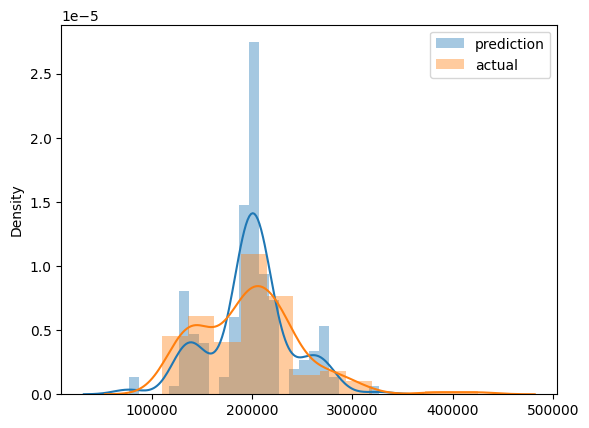

In [113]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

c:\Users\2024\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


31648.219425044535